# Evaluate Results with Multiclass ROC Analysis

**Goal of this analysis:** Understand our best model's ability to distinguish between the different tumor classes, how the model handles some class imbalance, and generate visuals for threshold selection and comparison.


**1) Prepare Data:** Convert the multiclass labels into a binary format for analysis.

**2) Compute ROC and AUC:** Calculate ROC curves and AUC scores for each class using a One versus Rest strategy (OvR)

**3) Average AUC:** Compute btoh micro-averaged and macro-averaged AUC scores to evaluate overall model performance.

**4) Plotting Curves:** Plot the ROC curves for each class and the averaged ROC curves to visualize the model's performance.

## Importing Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle

import os
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns

## Load in Test Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Change directory to 'DATASCI207_FinalProject'
os.chdir('/content/drive/My Drive/DATASCI207_FinalProject')
tf.keras.backend.clear_session()

In [7]:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Load each Model:

In [8]:
# Load the baseline model:
baseline_model = tf.keras.models.load_model("baseline_model_fit.keras")

In [9]:
# Load the 2-layer CNN model:
model_2_layers = tf.keras.models.load_model("model_2_layers.keras")

In [10]:
# Load the 3-layer CNN model:
model_3_layers = tf.keras.models.load_model("model_3_layers.keras")

In [11]:
# Load the hybrid CNN-Transformer model:
hybrid_transformer_cnn_model = tf.keras.models.load_model("hybrid_transformer_cnn_model.keras")

# One-versus-Rest Classification
In order to measure the effectiveness of each model for each class of tumor, we will run a One-vs-Rest (OvR) classification to generate ROC curves and AUC scores.

In [12]:
# convert y-test to binary format for computation
n_classes = Y_test.max() + 1
Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3])

In [13]:
# Load hybrid model (best performance)
best_model = tf.keras.models.load_model("hybrid_transformer_cnn_model.keras")

### Generate ROC Curves, AUC Scores, and Confusion Matrix for each Model:

In [14]:
def evaluate_model(model, X_test, Y_test, class_names):

    model_dict = {baseline_model: 'Baseline',
                  model_2_layers: '2-Layer CNN',
                  model_3_layers: '3-Layer CNN',
                  hybrid_transformer_cnn_model: 'Hybrid CNN-Transformer'}

    # Determine the model name based on the dictionary key
    model_name = model

    model_key = model_dict[model_name]

    print(model_key)

    # Binarize the output labels
    Y_test_bin = label_binarize(Y_test, classes=np.arange(len(class_names)))


    # Predict probabilities
    Y_test_pred = model.predict(X_test)

    # Compute ROC AUC for each tumor class
    fpr, tpr, aucs = {}, {}, {}
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_test_pred[:, i])
        aucs[i] = auc(fpr[i], tpr[i])

    # Compute micro and macro average AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_test_pred.ravel())
    aucs["micro"] = auc(fpr["micro"], tpr["micro"])

    # plot ROC curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {aucs["micro"]:.2f})')
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_name} (area = {aucs[i]:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_key}')
    plt.legend(loc="lower right")
    plt.show()

    # generate confusion matrix
    Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)
    conf_matrix = confusion_matrix(Y_test, Y_test_pred_classes)

    # plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix: {model_key}')
    plt.show()

    # gen classification report for analysis
    report = classification_report(Y_test, Y_test_pred_classes, target_names=class_names)
    print(f"Classification Report: {model_key}\n", report)


### Visualizations for each Model:

In [21]:
# Set class names
class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']

### Baseline Model:

Evaluating Baseline Model:
Baseline
38/38 [==============================] - 1s 20ms/step


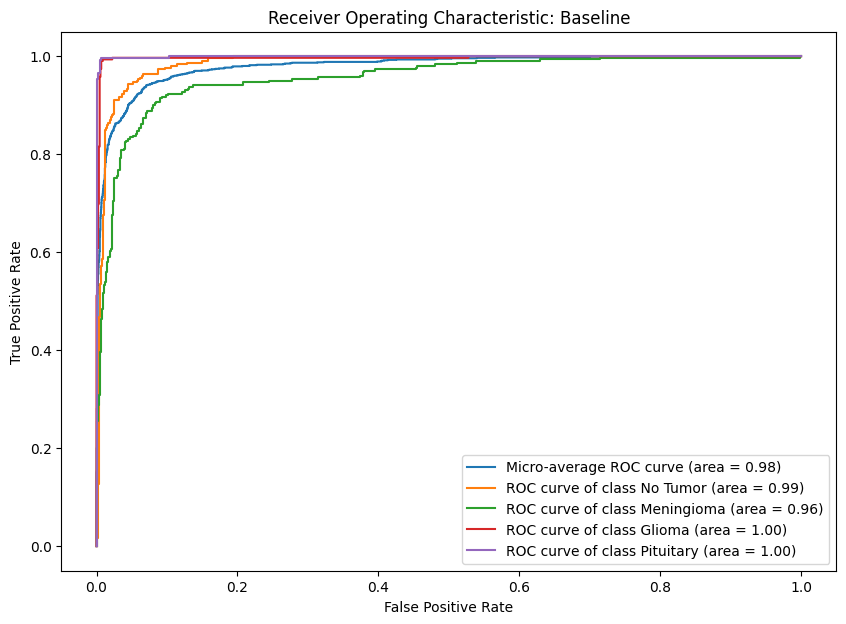

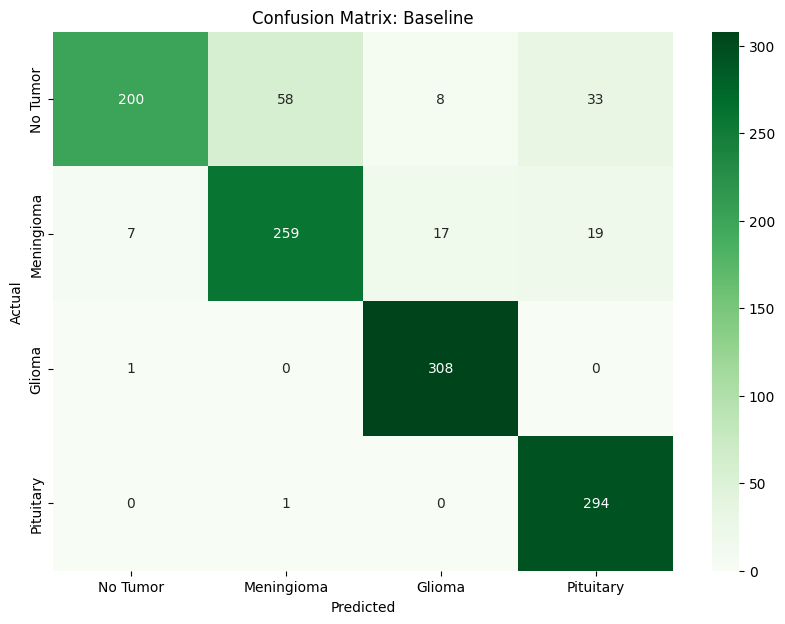

Classification Report: Baseline
               precision    recall  f1-score   support

    No Tumor       0.96      0.67      0.79       299
  Meningioma       0.81      0.86      0.84       302
      Glioma       0.92      1.00      0.96       309
   Pituitary       0.85      1.00      0.92       295

    accuracy                           0.88      1205
   macro avg       0.89      0.88      0.88      1205
weighted avg       0.89      0.88      0.88      1205



In [22]:
# Run evaluation function on baseline model:
print("Evaluating Baseline Model:")
evaluate_model(baseline_model, X_test, Y_test, class_names)


Evaluating 2-Layer CNN Model:
2-Layer CNN
38/38 [==============================] - 1s 22ms/step


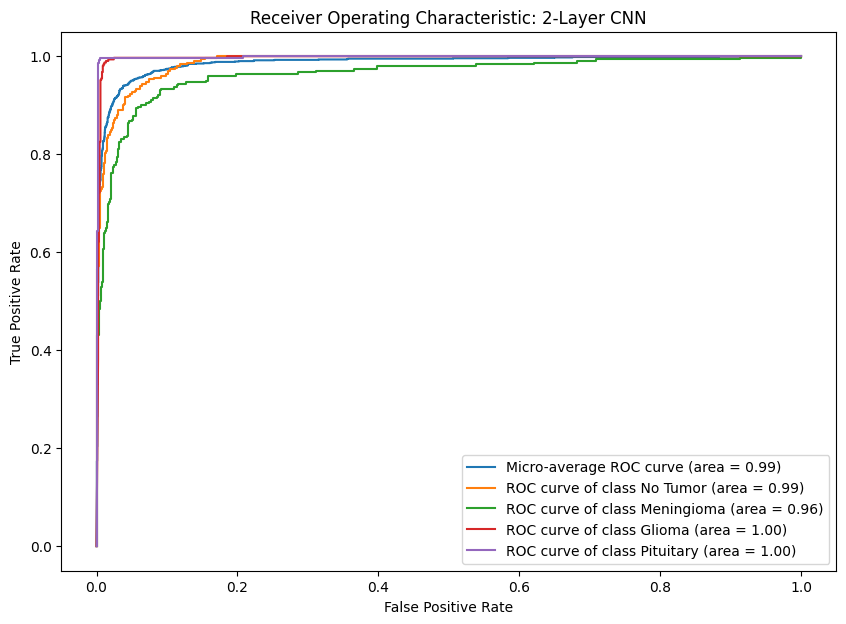

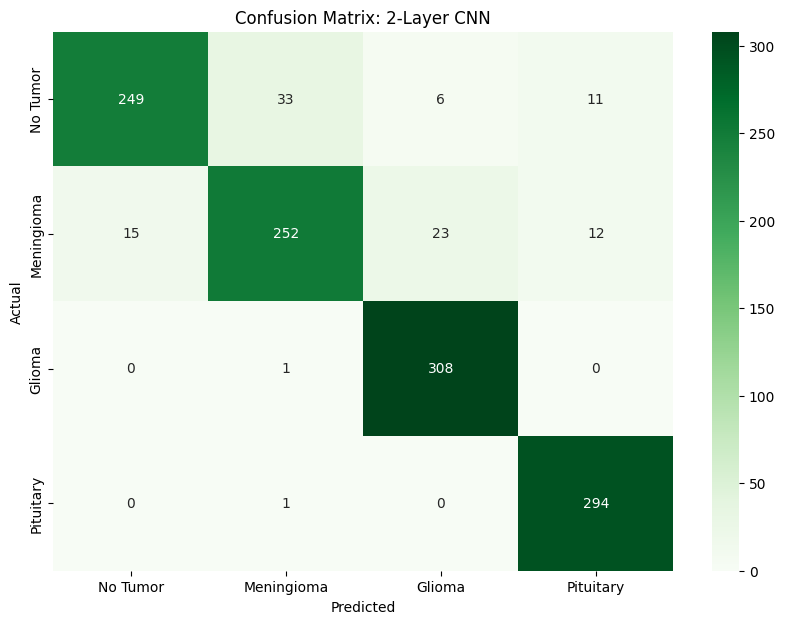

Classification Report: 2-Layer CNN
               precision    recall  f1-score   support

    No Tumor       0.94      0.83      0.88       299
  Meningioma       0.88      0.83      0.86       302
      Glioma       0.91      1.00      0.95       309
   Pituitary       0.93      1.00      0.96       295

    accuracy                           0.92      1205
   macro avg       0.92      0.92      0.91      1205
weighted avg       0.92      0.92      0.91      1205



In [23]:
# Run evaluation function on 2-Layer CNN model:
print("\nEvaluating 2-Layer CNN Model:")
evaluate_model(model_2_layers, X_test, Y_test, class_names)


Evaluating 3-Layer CNN Model:
3-Layer CNN
38/38 [==============================] - 1s 24ms/step


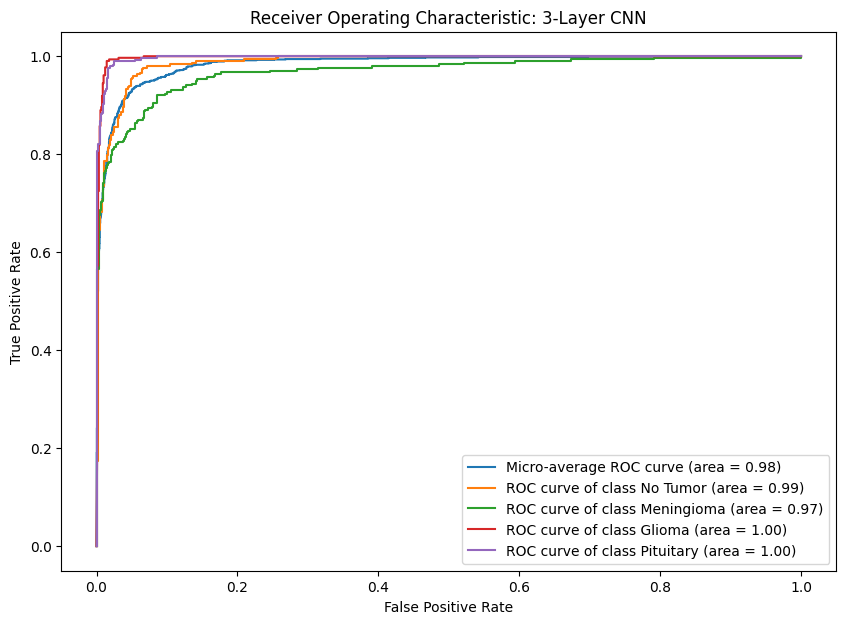

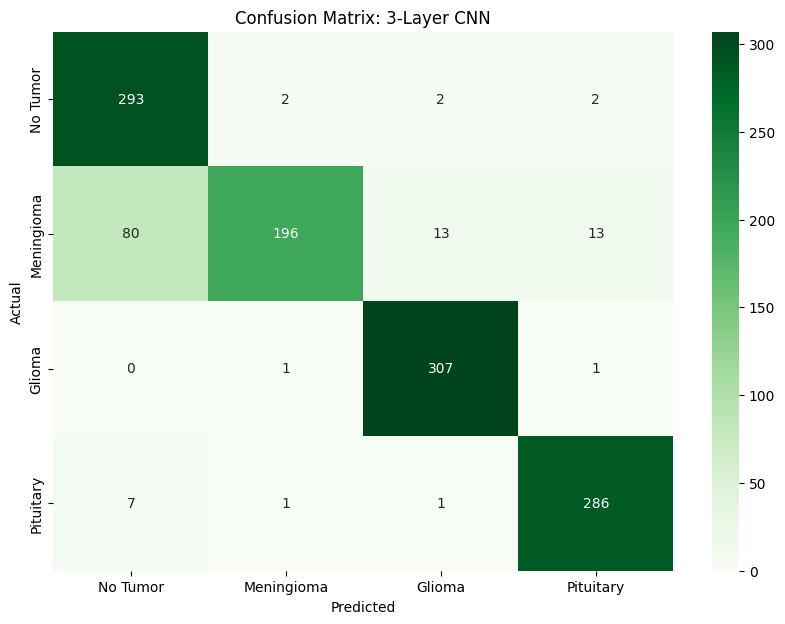

Classification Report: 3-Layer CNN
               precision    recall  f1-score   support

    No Tumor       0.77      0.98      0.86       299
  Meningioma       0.98      0.65      0.78       302
      Glioma       0.95      0.99      0.97       309
   Pituitary       0.95      0.97      0.96       295

    accuracy                           0.90      1205
   macro avg       0.91      0.90      0.89      1205
weighted avg       0.91      0.90      0.89      1205



In [24]:
# Run evaluation function on 3-Layer CNN model:
print("\nEvaluating 3-Layer CNN Model:")
evaluate_model(model_3_layers, X_test, Y_test, class_names)


Evaluating Hybrid Model:
Hybrid CNN-Transformer
38/38 [==============================] - 12s 294ms/step


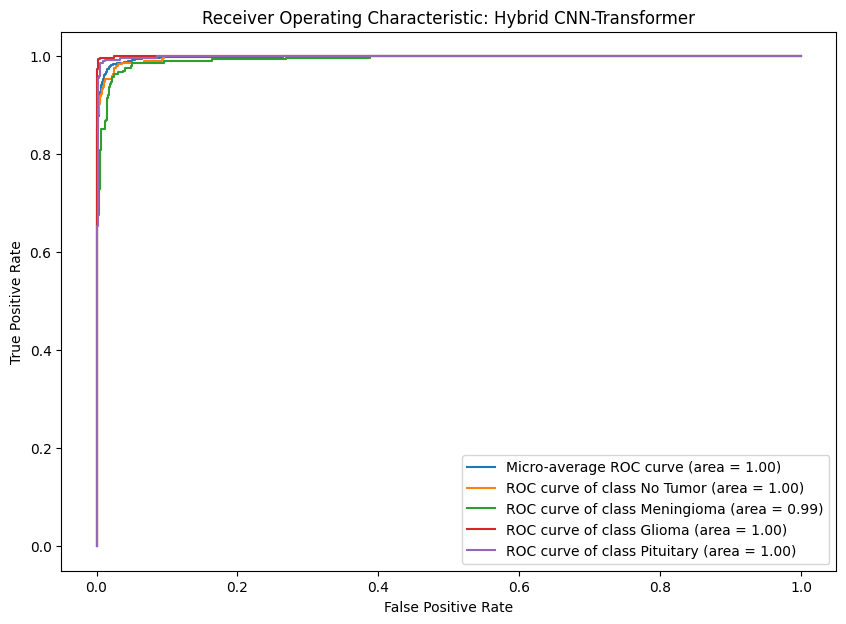

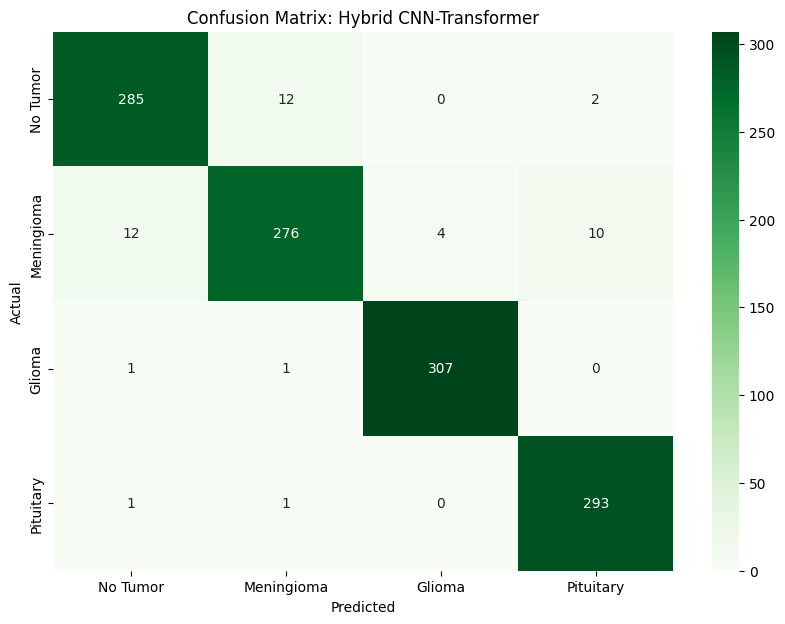

Classification Report: Hybrid CNN-Transformer
               precision    recall  f1-score   support

    No Tumor       0.95      0.95      0.95       299
  Meningioma       0.95      0.91      0.93       302
      Glioma       0.99      0.99      0.99       309
   Pituitary       0.96      0.99      0.98       295

    accuracy                           0.96      1205
   macro avg       0.96      0.96      0.96      1205
weighted avg       0.96      0.96      0.96      1205



In [25]:
# Run evaluation function on Hybrid CNN-Transformer model:
print("\nEvaluating Hybrid Model:")
evaluate_model(hybrid_transformer_cnn_model, X_test, Y_test, class_names)